In [1]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df, test_df,
                label_columns=None, batch_size=32):
        # Store the raw data.
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='new_cases', max_subplots=1):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', linestyle="-", edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [d]')


    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv")
df = df.replace(np.nan, 0) 
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d')

In [4]:
df.head()

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,cases_child,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,4,4,0,4,0,4,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,3,0,7,0,3,0,0,0,1,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


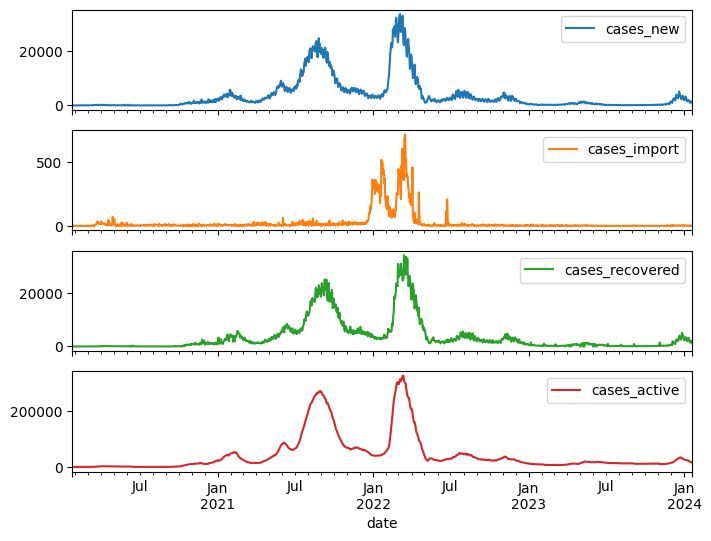

In [5]:
plot_cols = ['cases_new', 'cases_import', 'cases_recovered', "cases_active"]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cases_new,1457.0,3613.841455,5954.317880,0.0,182.0,1384.0,3780.0,33406.0
cases_import,1457.0,26.838023,83.126161,0.0,1.0,4.0,10.0,719.0
cases_recovered,1457.0,3577.477008,5905.251973,0.0,160.0,1390.0,3804.0,33872.0
cases_active,1457.0,43642.861359,66137.851106,1.0,10129.0,18280.0,43883.0,323791.0
cases_cluster,1457.0,366.724777,661.009527,0.0,0.0,27.0,447.0,3394.0
cases_unvax,1457.0,1398.457790,2499.087764,0.0,38.0,201.0,1458.0,12681.0
cases_pvax,1457.0,299.695264,1084.673705,0.0,0.0,4.0,27.0,7315.0
cases_fvax,1457.0,967.132464,2083.567121,0.0,0.0,82.0,558.0,13060.0
cases_boost,1457.0,948.555937,2435.958529,0.0,0.0,82.0,840.0,18170.0
cases_child,1457.0,442.281400,827.382406,0.0,11.0,98.0,364.0,4389.0


In [7]:

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
test_df = df[int(n*0.7):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


In [8]:
num_of_days = 30
wide_window = WindowGenerator(input_width=num_of_days, label_width=num_of_days, shift=0, train_df=train_df, test_df=test_df, label_columns=["cases_new"])
print(wide_window)

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label column name(s): ['cases_new']


In [9]:
lstm_single_step = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(30, return_sequences=True),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(15, return_sequences=True),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1)
    ]
)

In [10]:
tf.keras.utils.plot_model(lstm_single_step, show_shapes=True)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
MAX_EPOCHS = 500

def compile_and_fit(model, window, patience=10):
    logpath = ("tensorboard_log")
    tb = tf.keras.callbacks.TensorBoard(logpath)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        callbacks=[tb, early_stopping])
    return history

In [ ]:
history_single_step = compile_and_fit(lstm_single_step, wide_window)

Epoch 1/500

31/31 [==============================] - 4s 14ms/step - loss: 0.2620 - mean_absolute_percentage_error: 173.2215
Epoch 2/500
31/31 [==============================] - 0s 15ms/step - loss: 0.1011 - mean_absolute_percentage_error: 98.1168
Epoch 3/500
31/31 [==============================] - 0s 15ms/step - loss: 0.0686 - mean_absolute_percentage_error: 91.0828
Epoch 4/500
31/31 [==============================] - 0s 15ms/step - loss: 0.0580 - mean_absolute_percentage_error: 87.5327
Epoch 5/500
31/31 [==============================] - 1s 16ms/step - loss: 0.0509 - mean_absolute_percentage_error: 82.4661
Epoch 6/500
31/31 [==============================] - 1s 16ms/step - loss: 0.0455 - mean_absolute_percentage_error: 77.1446
Epoch 7/500
31/31 [==============================] - 1s 16ms/step - loss: 0.0405 - mean_absolute_percentage_error: 74.8089
Epoch 8/500
31/31 [==============================] - 1s 18ms/step - loss: 0.0351 - mean_absolute_percentage_error: 72.2866
Epoch 9/500
31

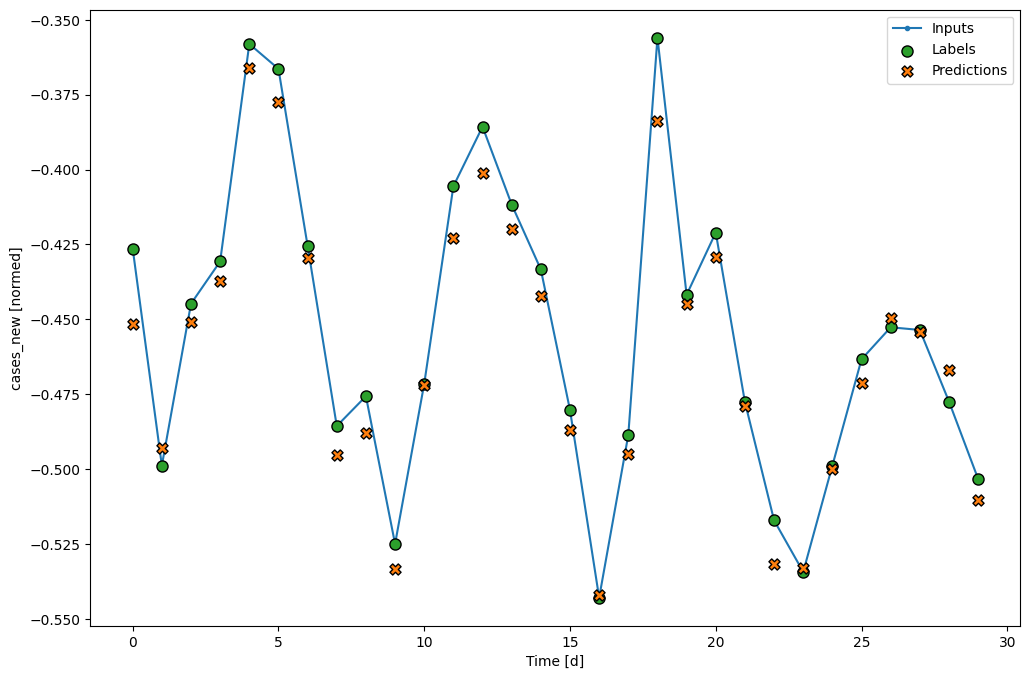

In [ ]:
wide_window.plot(lstm_single_step, "cases_new")

In [ ]:
print(history_single_step.model)

In [ ]:
history_single_step.history.keys()

dict_keys(['loss', 'mean_absolute_percentage_error'])

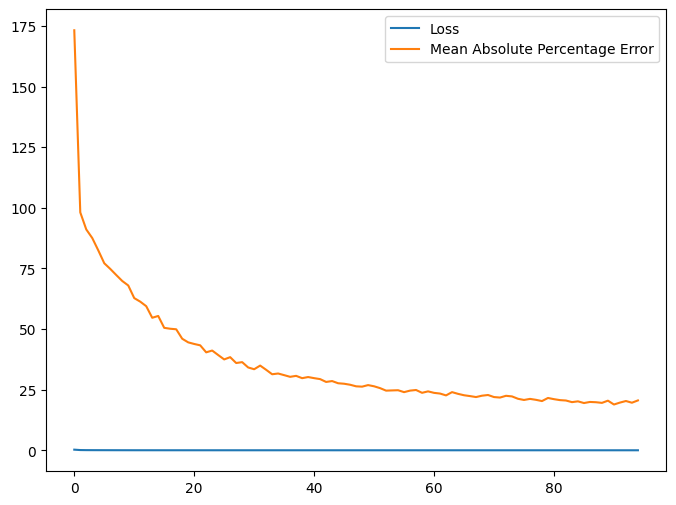

In [ ]:
plt.figure()
plt.plot(history_single_step.history["loss"])
plt.plot(history_single_step.history["mean_absolute_percentage_error"])
plt.legend(["Loss", "Mean Absolute Percentage Error"])
plt.show()

In [ ]:
lstm_single_step.evaluate(wide_window.test)

13/13 [==============================] - 1s 9ms/step - loss: 1.1382e-04 - mean_absolute_percentage_error: 1.9174


[0.00011382139200577512, 1.9174482822418213]

AttributeError: module 'pydot' has no attribute 'InvocationException'